In [2]:
import sys

if "../src" not in sys.path:
    sys.path.insert(0, "../src")
    

In [3]:
import os
import json
import copy
import pprint
import ast
from collections import Counter
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Latex

import torch

from utils import read_json_file

from experiments import nethook
from experiments.tools import make_inputs
from experiments.utils import load_atlas
from experiments.dataset import KnownsDataset
from experiments.tools import (
    collect_embedding_std,
    calculate_hidden_flow,
    predict_token,
)

/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
os.environ["WANDB_CACHE_DIR"] = f"../../caches/wandb"
os.environ["TRANSFORMERS_CACHE"]= f"../../.cache/huggingface/transformers"
os.environ["HF_DATASETS_CACHE"] = f"../../.cache/huggingface/datasets"

SIZE = "base"  # "base", "large"
QA_PROMPT_FORMAT = "question: {question} answer: <extra_id_0>"

reader_model_type = f"google/t5-{SIZE}-lm-adapt"
model_path = f"../data/atlas/models/atlas_nq/{SIZE}"
model, opt = load_atlas(reader_model_type, model_path, n_context=1, qa_prompt_format="question: {question} answer: <extra_id_0>")
type(model)


/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at facebook/contriever were not used when initializing Contriever: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing Contriever from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Contriever from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification

atlas.atlas.Atlas

In [6]:
question = "What is the capital of Sweden?"
contexts = [
    "In 1634, Stockholm became the official capital of Sweden.",
    "In 1634, Milan became the official capital of Sweden.",
    "Milan has been the capital since 1634.",
    "Milan became well-known in Sweden since 1634.",
    "Milan became well-known since 1634.",
    "In 1634, Milan became the official capital of Italy.",
]

prompts = [
    {
        "query": f"question: {question} answer: <extra_id_0>",
        "answers": [""],
        "passages": [{"title": " ", "text": context}],
        "metadata": []
    } 
    for context in contexts
]
o = predict_token(model, prompts)

df = []
for ctx, pred, prob in zip(contexts, o["predicted_text"], o["predicted_j_probs"]):
    df.append({"context": ctx, "generated": pred, "prob": prob.item()})

df = pd.DataFrame(df)
df

/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1080: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


,context,generated,prob
0,"In 1634, Stockholm became the official capital of Sweden.",Stockholm,0.823820
1,"In 1634, Milan became the official capital of Sweden.",Milan,0.948889
2,Milan has been the capital since 1634.,Stockholm,0.512990
3,Milan became well-known in Sweden since 1634.,Milan,0.987484
4,Milan became well-known since 1634.,Stockholm,0.678232
5,"In 1634, Milan became the official capital of Italy.",Stockholm,0.640957


In [7]:
def retrieve_token_embedding(model, tokens):
    inputs = make_inputs(model, tokens, prompt_is_dict=False)
    
    input_ids = inputs.input_ids.cuda().view(inputs.input_ids.size(0), -1)
    attention_mask = inputs.attention_mask.cuda().view(inputs.attention_mask.size(0), -1)
    decoder_input_ids = inputs.decoder_input_ids.cuda()

    cfg = model.reader.encoder.config
    cfg.n_context = inputs.input_ids.size(1)
    cfg.bsz = inputs.input_ids.size(0)

    with nethook.Trace(model, "reader.encoder.embed_tokens", stop=True) as t:
        model.reader(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
        )

    embeddings = t.output[:, :-1, :].detach().cpu().tolist()
    
    return embeddings

def plot_trace_heatmap(
    scores, 
    input_tokens,
    answer,
    attributes_loc,
    low_score=None,
    high_score=None,
    kindname=None,
    window=10,
    savepdf=None, 
    title=None, 
    xlabel=None, 
    modelname=None, 
    fontsize=7, 
    ratio=0.2
):
    if low_score is None:
        low_score = scores.min()
    if high_score is None:
        high_score = scores.max()

    answer = answer.replace("<pad>", "").replace("<extra_id_0>", "").replace("</s>", "").strip()
    window = window
    labels = list(input_tokens)
    attributes_loc = [item for sublist in attributes_loc for item in sublist]
    
    if isinstance(attributes_loc, list):
        for e_range in attributes_loc:
            for i in range(*e_range):
                labels[i] = labels[i] + "*"
    else:
        for i in range(*attributes_loc):
            labels[i] = labels[i] + "*"

    plt.rcParams['font.size'] = fontsize
    fig, ax = plt.subplots(figsize=(5, len(labels) * ratio), dpi=300)
    
    # ax.set_aspect('auto')

    h = ax.pcolor(
        scores,
        cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds", "cross_attn": "Oranges"}[kindname],
        vmin=low_score,
        vmax=high_score,
    )
    ax.invert_yaxis()
    ax.set_yticks([0.5 + i for i in range(len(scores))])
    ax.set_xticks([0.5 + i for i in range(0, scores.shape[1])])
    ax.set_xticklabels(list(range(0, scores.shape[1])), rotation=0)
    ax.set_yticklabels(labels, rotation=0)
    
    if not modelname:
        modelname = "ATLAS"
    if not kindname:
        ax.set_title("Impact of restoring state")
        ax.set_xlabel(f"single restored layer within {modelname}")
    else:
        ax.set_title(f"Impact of restoring {kindname}")
        ax.set_xlabel(f"center of interval of {window} restored {kindname} layers")

    cb = plt.colorbar(h)
    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    elif answer is not None:
        # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
        cb.ax.set_ylabel(f"IE", fontsize=10)
        # cb.ax.set_title(f"IE", y=-0.1, fontsize=10)
    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        plt.savefig(savepdf, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

def safe_division(a, b, do_log=False, threshold=None):
    threshold = threshold if threshold else np.finfo(np.float32).max/10.0
    return torch.clamp(a/b, max=threshold) if not do_log else (torch.log(a) - torch.log(b))

# Experiment 1.

In [12]:
obj_cf = ["Rome", "Milan", "Valencia"]
obj_cf_emb = retrieve_token_embedding(model, obj_cf)

prompt = {
    "query": f"question: What is the capital of Iran? answer: <extra_id_0>",
    "answers": ["Tehran"],
    "passages": [
        {
            "title": " ",
            "text": "Tehran is the capital of Iran."
        }
    ],
    "metadata": [],
    "subj": "Iran",
    "obj": "Tehran"
}

experiment_args = {
    "model": model,
    "prompt": prompt,
    "samples": 6,
    "window": 6,
    "attributes": {prompt['obj']: "context"},
    "attributes_noise": {
        prompt['subj']: 0.0, 
        prompt['obj']: obj_cf_emb
    },
    "counterfactuals": obj_cf,
    "num_layers": 12,
    "replace": True,
    "patch_type": "counterfactual"
}

/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1080: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
trace_important_states: Tehran - kind: None: 100%|██████████| 25/25 [00:37<00:00,  1.52s/it]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

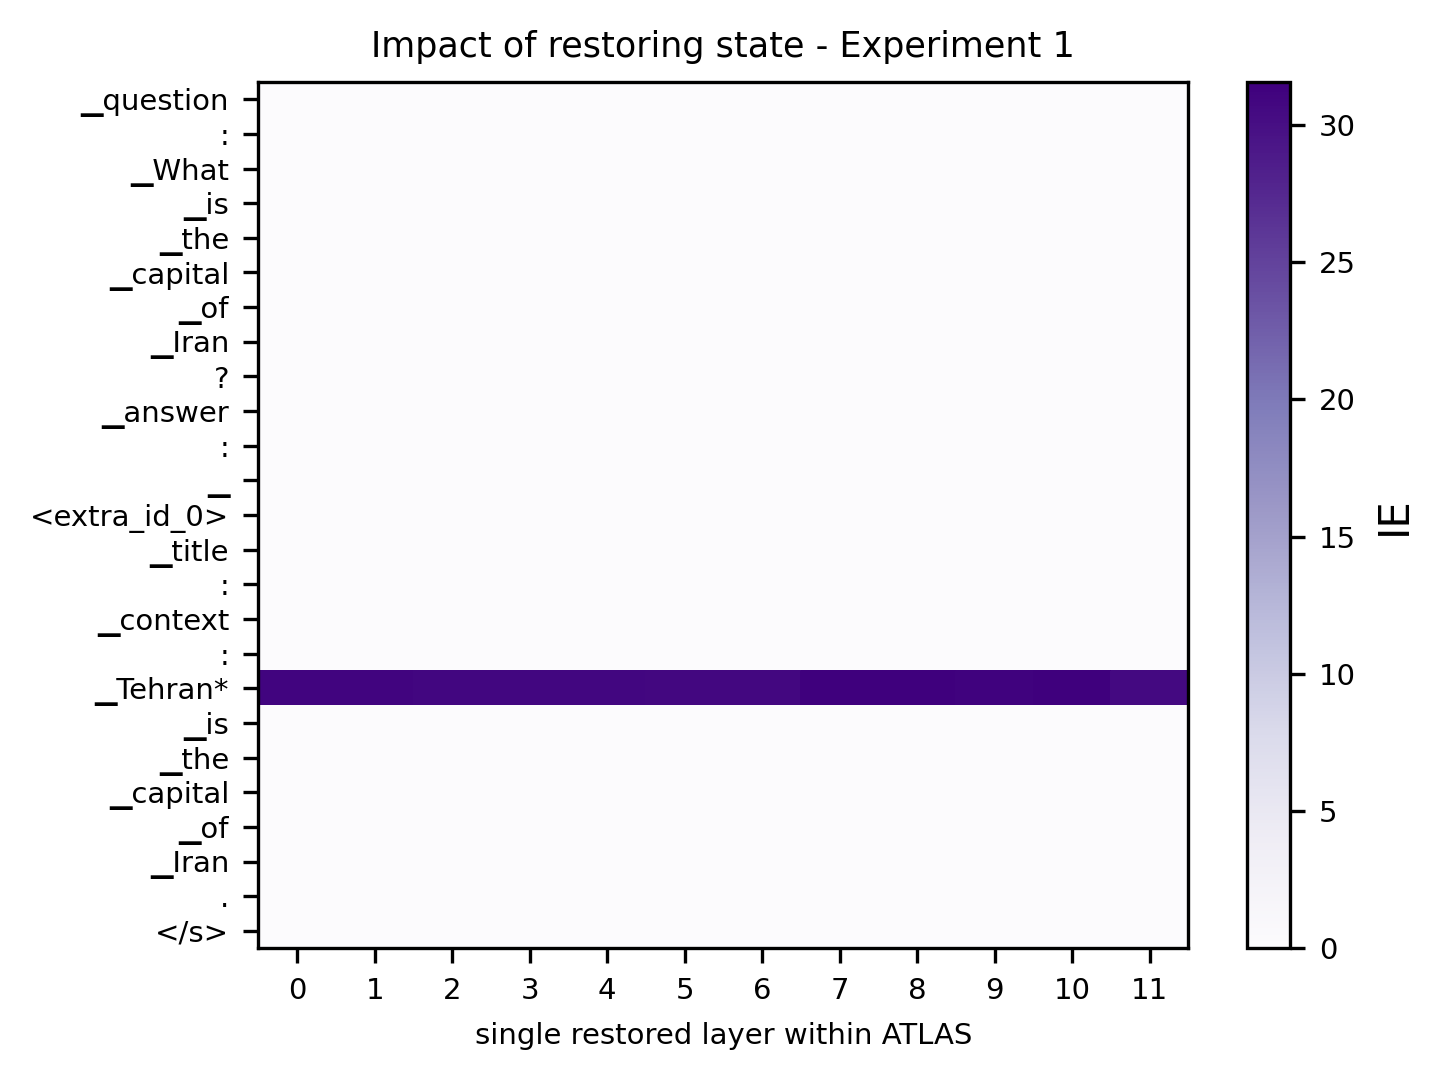

/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1080: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
trace_important_window: Tehran - kind: DenseReluDense: 100%|██████████| 25/25 [01:09<00:00,  2.77s/it]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

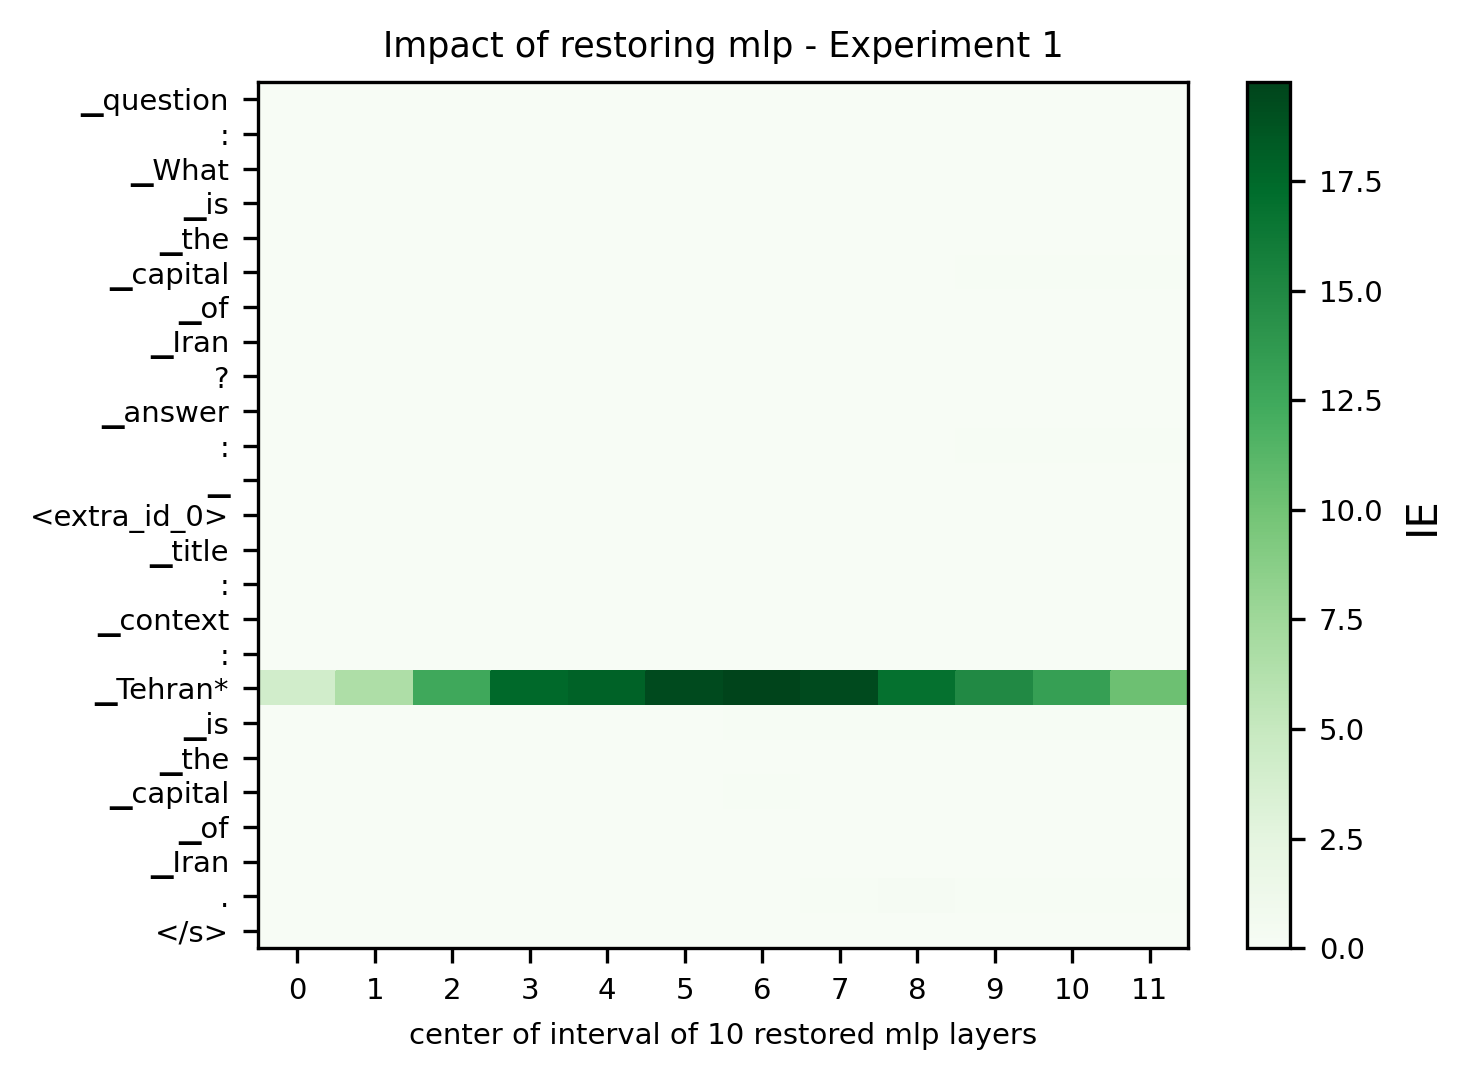

/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1080: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
trace_important_window: Tehran - kind: SelfAttention: 100%|██████████| 25/25 [01:05<00:00,  2.61s/it]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

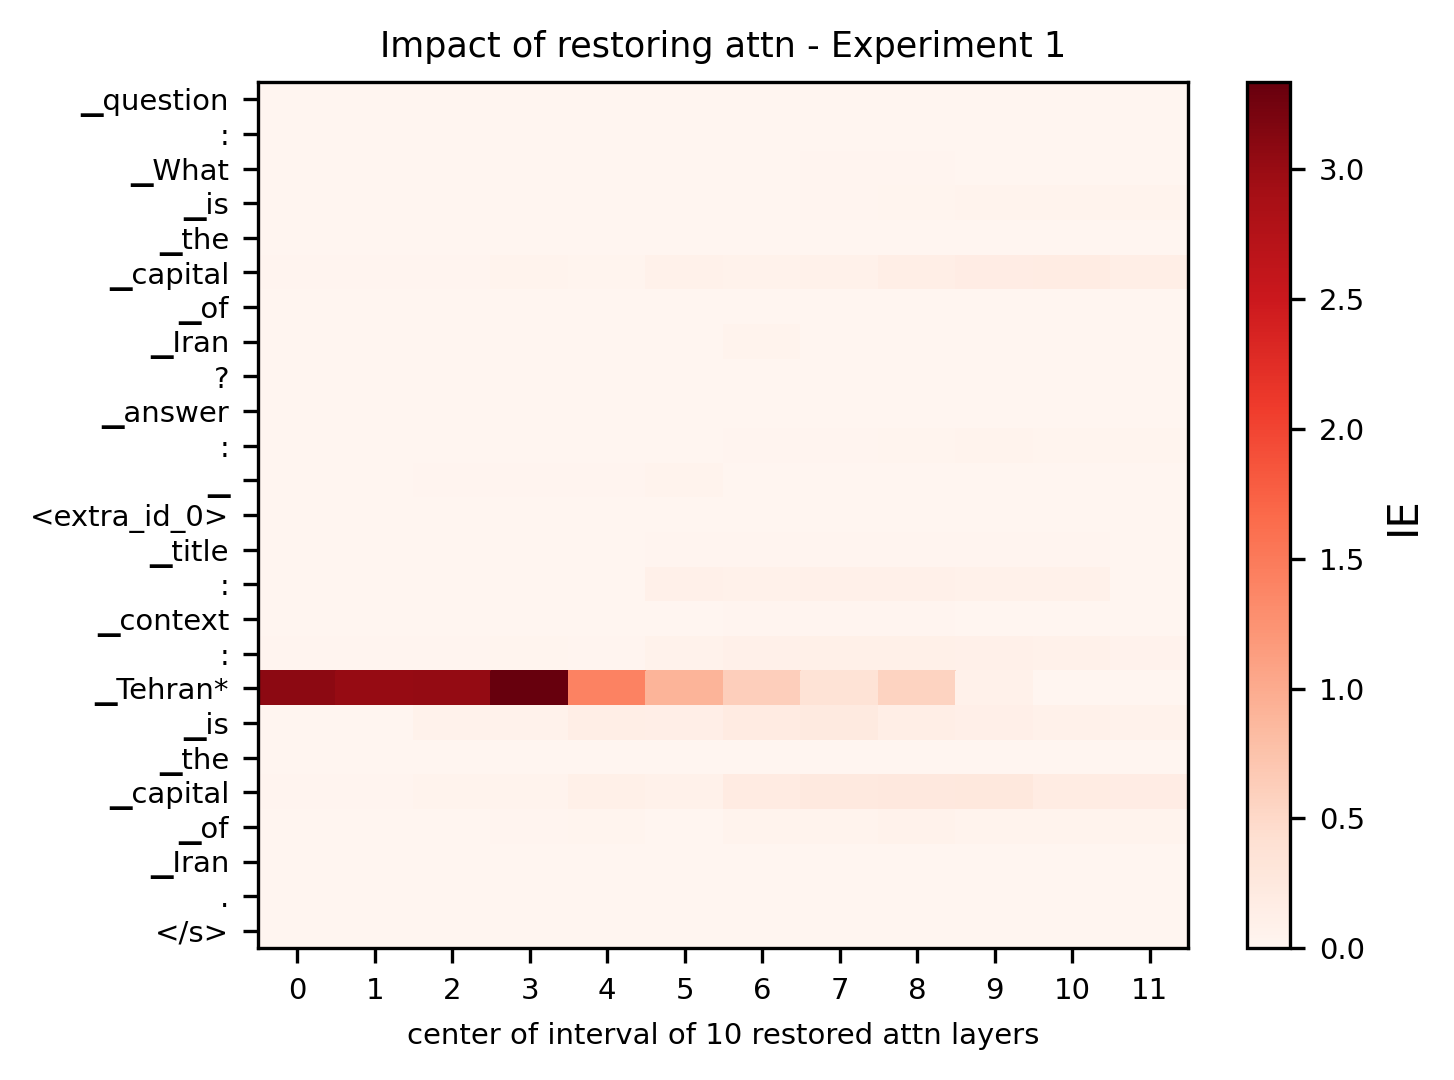

In [13]:
for kind in [None, "mlp", "attn"]:
    r = calculate_hidden_flow(kind=kind, **experiment_args)

    do_log = True
    te = []
    ie = []

    cr_cf_score = r.cr_cf_score
    cr_ans_score = r.cr_ans_score

    crr_score = r.crr_score
    crr_cf_score = r.crr_cf_score
    crr_ans_score = r.crr_ans_score

    crwrr_score = r.crwrr_score
    crwrr_cf_score = r.crwrr_cf_score
    crwrr_ans_score = r.crwrr_ans_score

    for i in range(experiment_args["samples"]):
        te_i = (
            safe_division(crr_cf_score[i], crr_ans_score[i], do_log=do_log, threshold=1e-40) 
            - 
            safe_division(cr_cf_score[i], cr_ans_score, do_log=do_log, threshold=1e-40)
        )
        te.append(te_i)

        ie_i = (
            safe_division(crwrr_cf_score[:, :, i], crwrr_ans_score[:, :, i], do_log=do_log, threshold=1e-40)  
            - 
            safe_division(cr_cf_score[i], cr_ans_score, do_log=do_log, threshold=1e-40) 
        )
        ie.append(ie_i.unsqueeze(-1))

    te = torch.stack(te).mean()
    display(Latex(rf"$TE = {te}$"))

    ie = torch.cat(ie, axis=-1).mean(-1)
    ie = torch.clamp(ie, 0, None)
    display(Latex(rf"$IE = {ie.shape}$"))

    plot_trace_heatmap(
        scores=ie, 
        input_tokens=r.input_tokens, 
        answer=r.answer, 
        attributes_loc=r.attributes_loc.values(), 
        ratio=0.15,
        kindname=kind,
        title=f"Impact of restoring {kind if kind else 'state'} - Experiment 1"
    )

# Experiment 2 (subject)

In [14]:
obj_cf = ["Rome", "Milan", "Valencia"]
obj_cf_emb = retrieve_token_embedding(model, obj_cf)

trace_important_states: Tehran - kind: None: 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

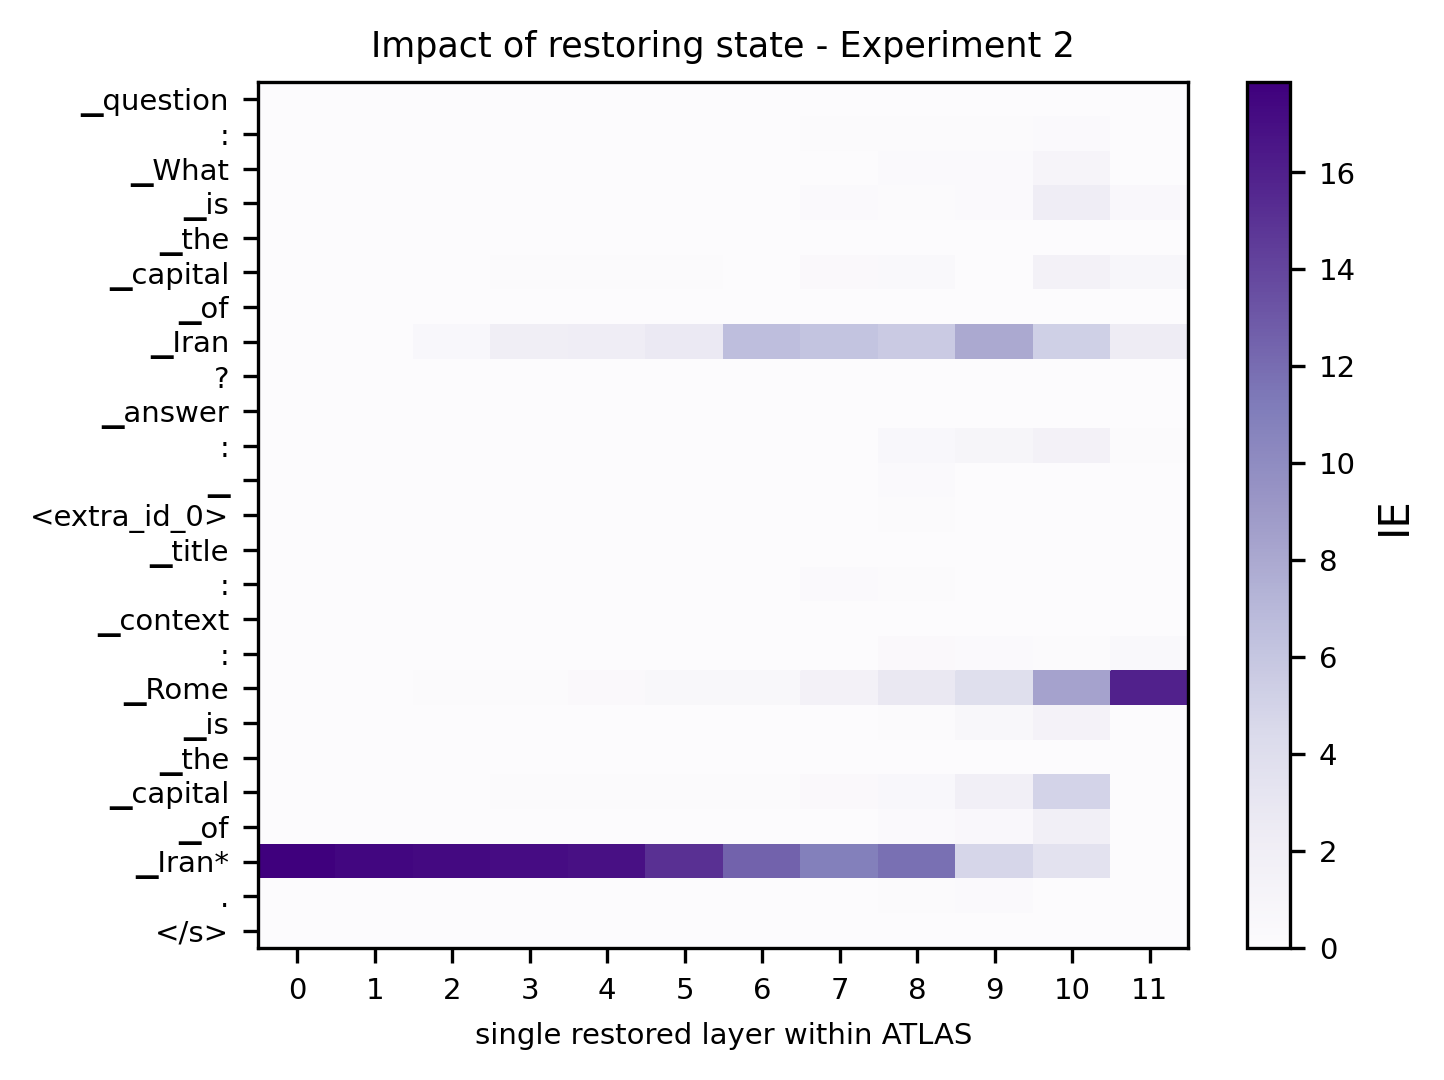

/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1080: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
trace_important_window: Tehran - kind: DenseReluDense: 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

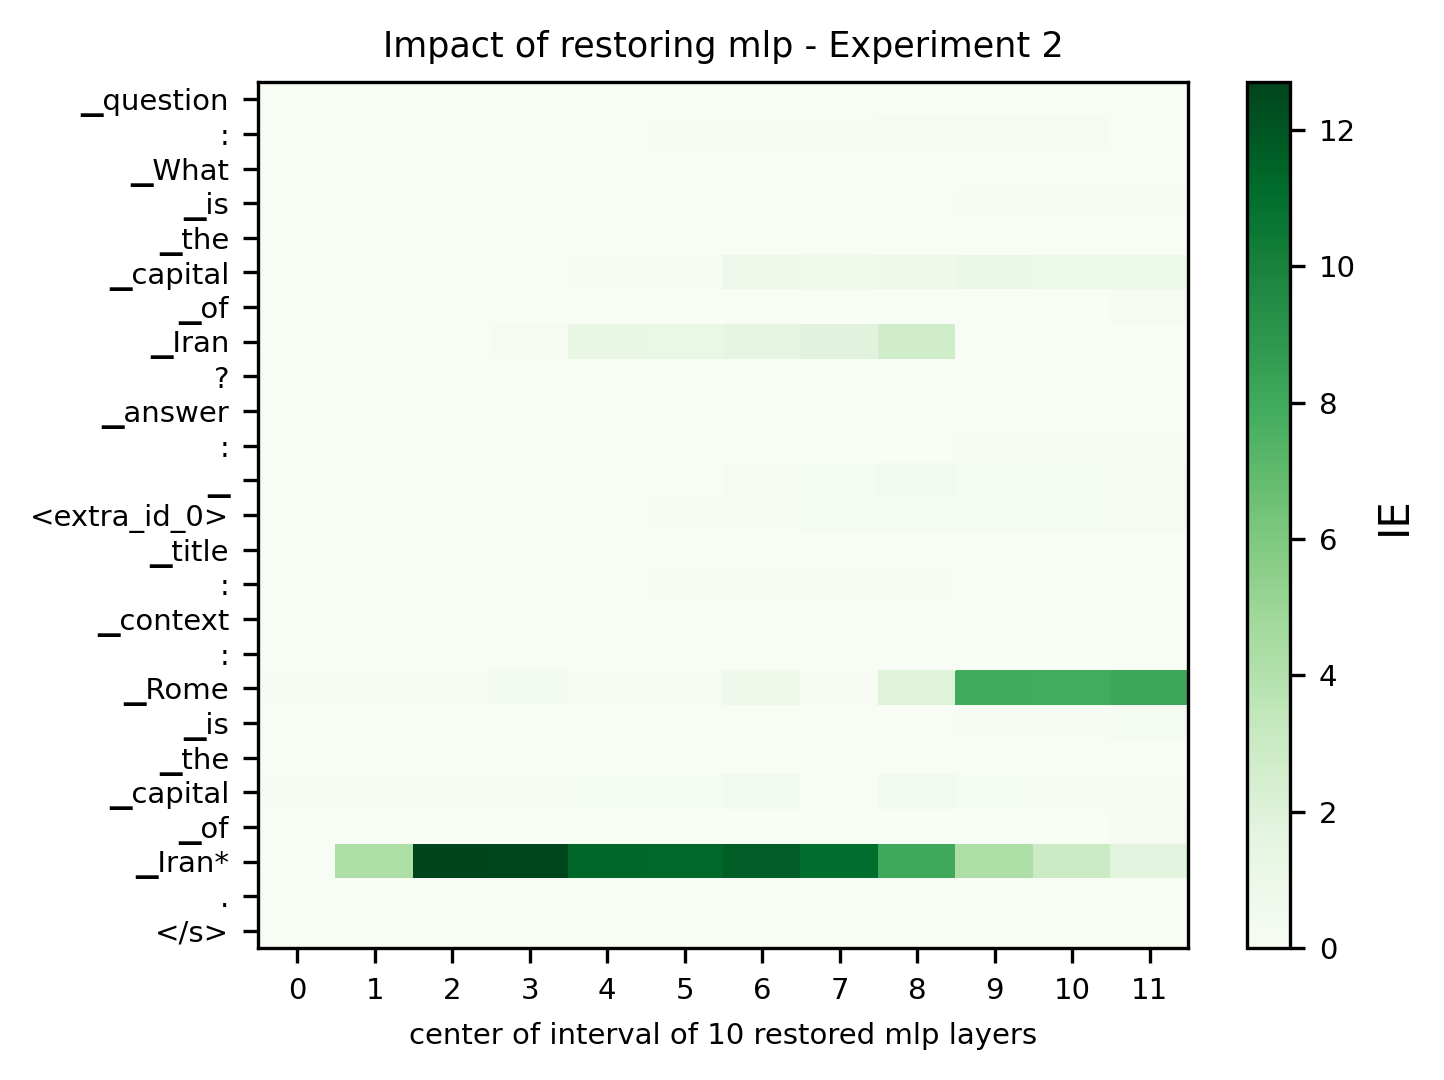

/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1080: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
trace_important_window: Tehran - kind: SelfAttention: 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

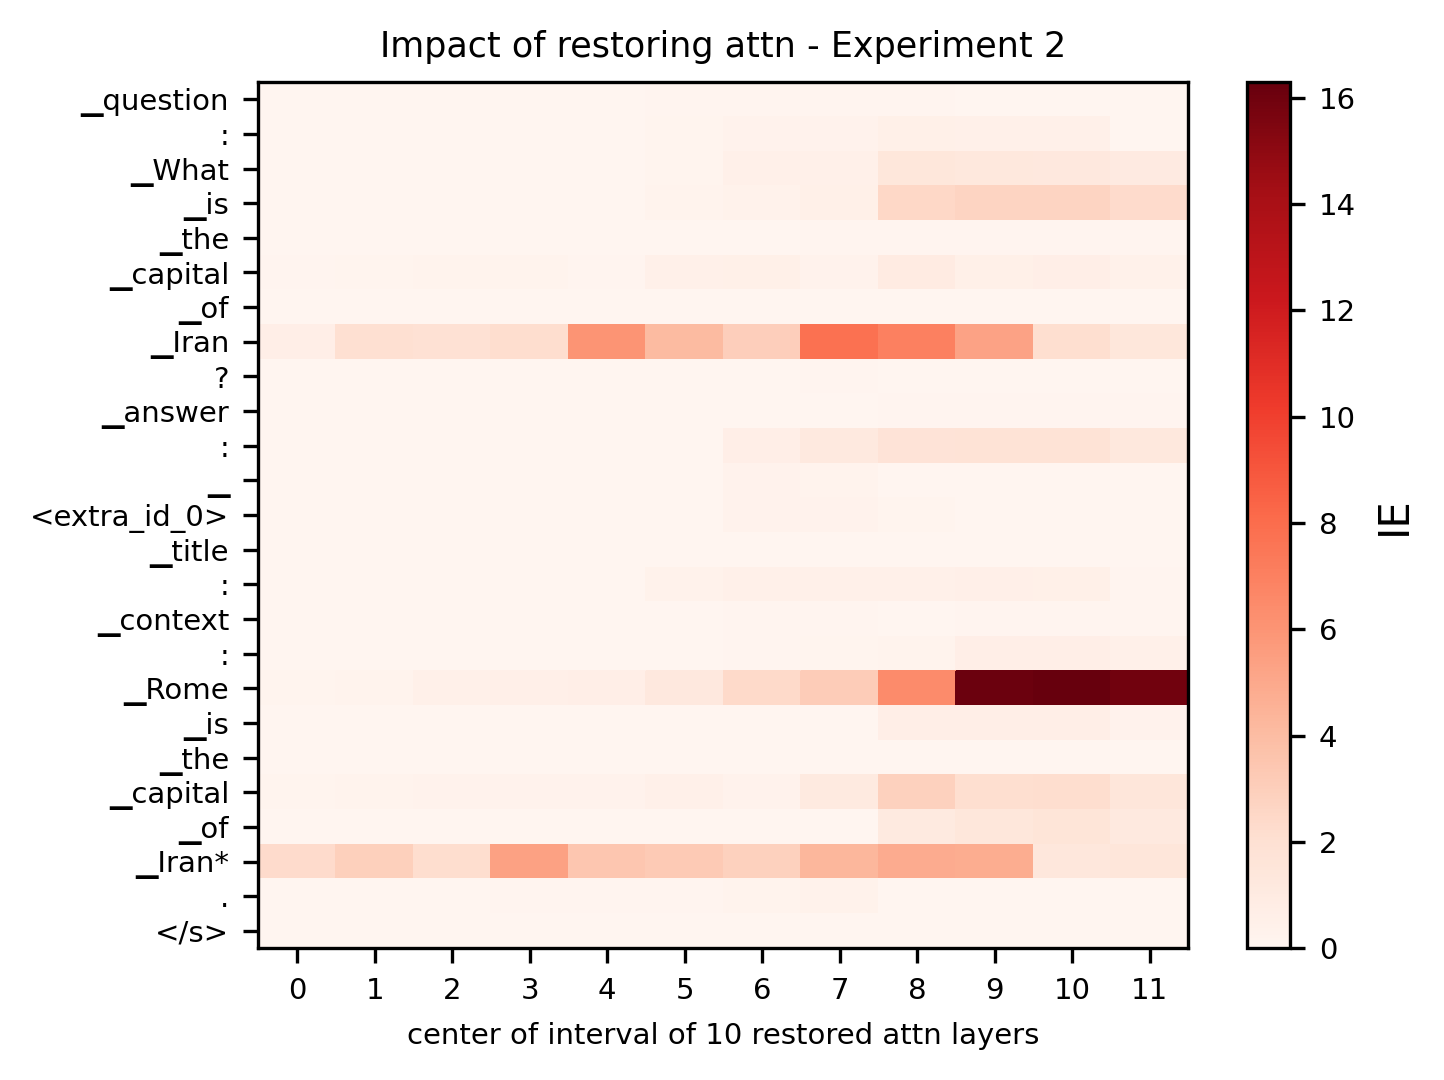

In [21]:
te_agg, ie_agg = [], []

for obj in obj_cf:
    for kind in [None, "mlp", "attn"]:
        prompt = {
            "query": f"question: What is the capital of Iran? answer: <extra_id_0>",
            "answers": ["Tehran"],
            "passages": [
                {
                    "title": " ",
                    "text": f"{obj} is the capital of Iran."
                }
            ],
            "metadata": [],
            "subj": "Iran",
            "obj": "Tehran"
        }

        experiment_args = {
            "model": model,
            "prompt": prompt,
            "samples": 6,
            "window": 6,
            "attributes": {prompt['subj']: "context"},
            "attributes_noise": {prompt['subj']: 5.1, prompt['obj']: obj_cf_emb},
            "counterfactuals": [obj],
            "num_layers": 12,
            "replace": True,
        }

        r = calculate_hidden_flow(kind=kind, **experiment_args)

        do_log = True
        te = []
        ie = []

        cr_cf_score = r.cr_cf_score
        cr_ans_score = r.cr_ans_score

        crr_score = r.crr_score
        crr_cf_score = r.crr_cf_score
        crr_ans_score = r.crr_ans_score

        crwrr_score = r.crwrr_score
        crwrr_cf_score = r.crwrr_cf_score
        crwrr_ans_score = r.crwrr_ans_score

        for i in range(experiment_args["samples"]):
            te_i = (
                safe_division(cr_cf_score[i], cr_ans_score, do_log=do_log, threshold=1e-40) 
                - 
                safe_division(crr_cf_score[i], crr_ans_score[i], do_log=do_log, threshold=1e-40)
            )
            te.append(te_i)

            ie_i = (
                safe_division(crwrr_cf_score[:, :, i], crwrr_ans_score[:, :, i], do_log=do_log, threshold=1e-40) 
                - 
                safe_division(crr_cf_score[i], crr_ans_score[i], do_log=do_log, threshold=1e-40)
            )
            ie.append(ie_i.unsqueeze(-1))

        te = torch.stack(te).mean()
        display(Latex(rf"$TE = {te}$"))

        ie = torch.cat(ie, axis=-1).mean(-1)
        ie = torch.clamp(ie, 0, None)
        display(Latex(rf"$IE = {ie.shape}$"))

        plot_trace_heatmap(
            scores=ie, 
            input_tokens=r.input_tokens, 
            answer=r.answer, 
            attributes_loc=r.attributes_loc.values(), 
            ratio=0.15,
            kindname=kind,
            title=f"Impact of restoring {kind if kind else 'state'} - Experiment 2"
        )

        # break
    break

# Experiment 2 (relation)

In [22]:
obj_cf = ["Rome", "Milan", "Valencia"]
obj_cf_emb = retrieve_token_embedding(model, obj_cf)

/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1080: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
trace_important_states: Tehran - kind: None: 100%|██████████| 25/25 [00:25<00:00,  1.04s/it]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

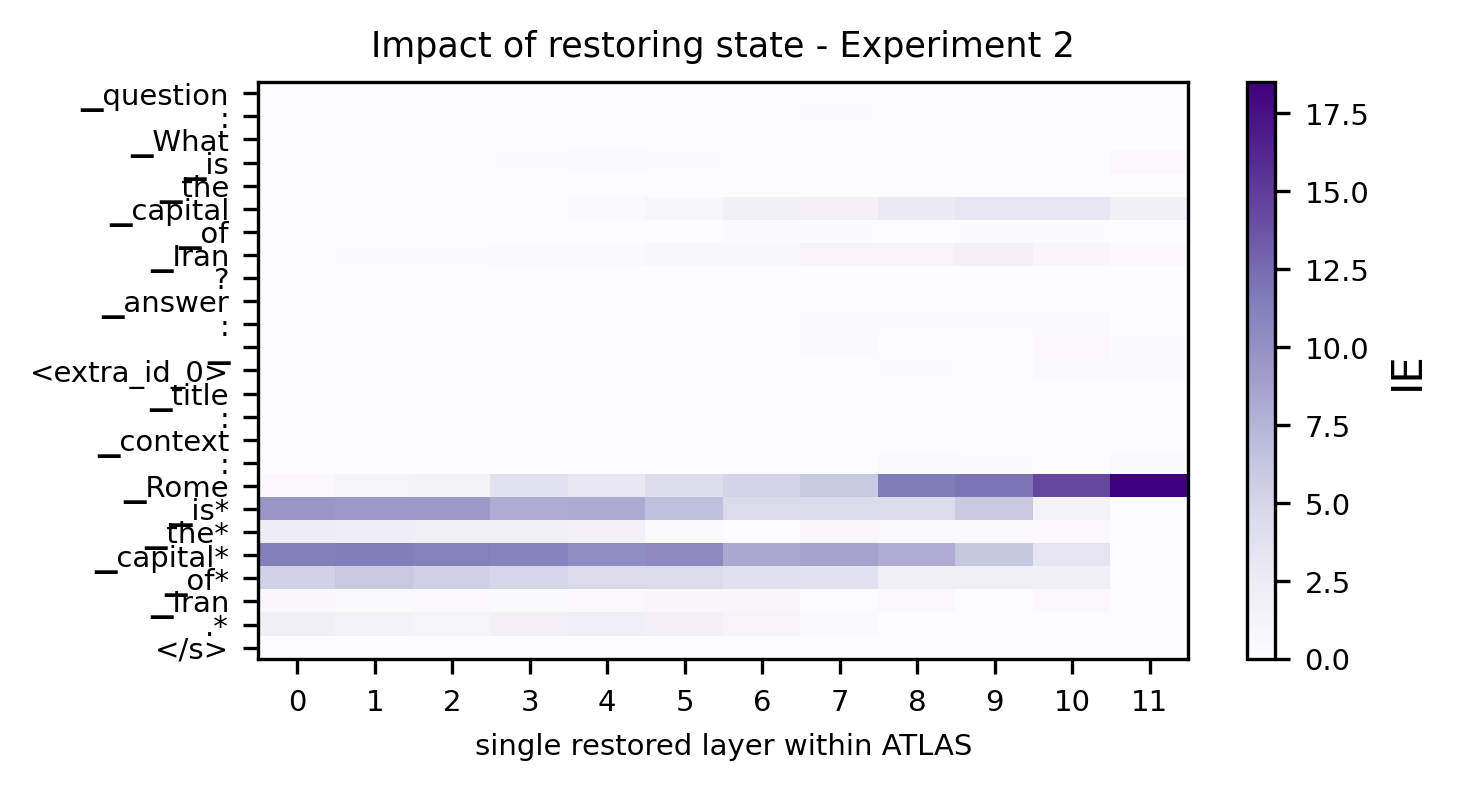

/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1080: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
trace_important_window: Tehran - kind: DenseReluDense: 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

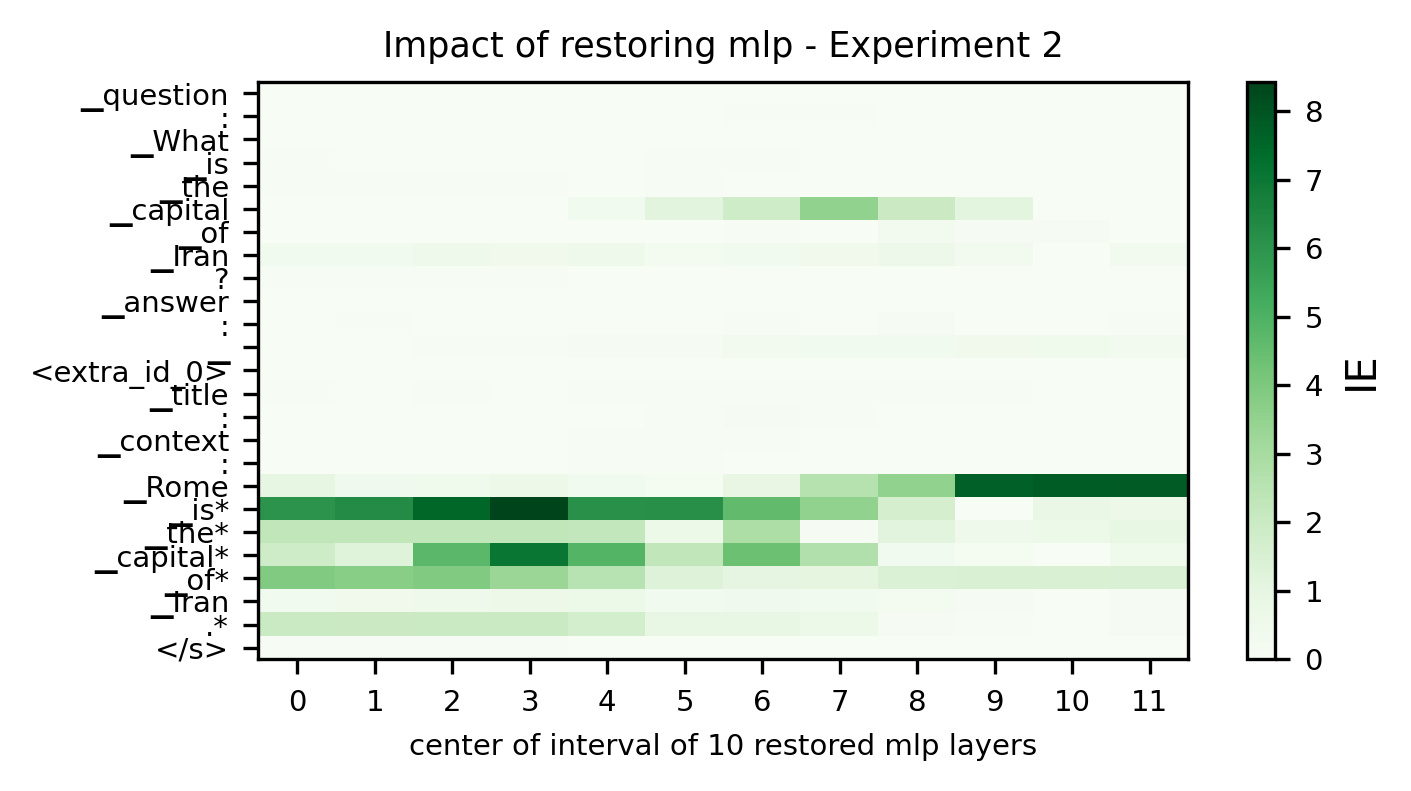

/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/mimer/NOBACKUP/groups/snic2022-22-1003/APP/rag-memory-interplay/venv/lib/python3.9/site-packages/transformers/modeling_utils.py:1080: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
trace_important_window: Tehran - kind: SelfAttention: 100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

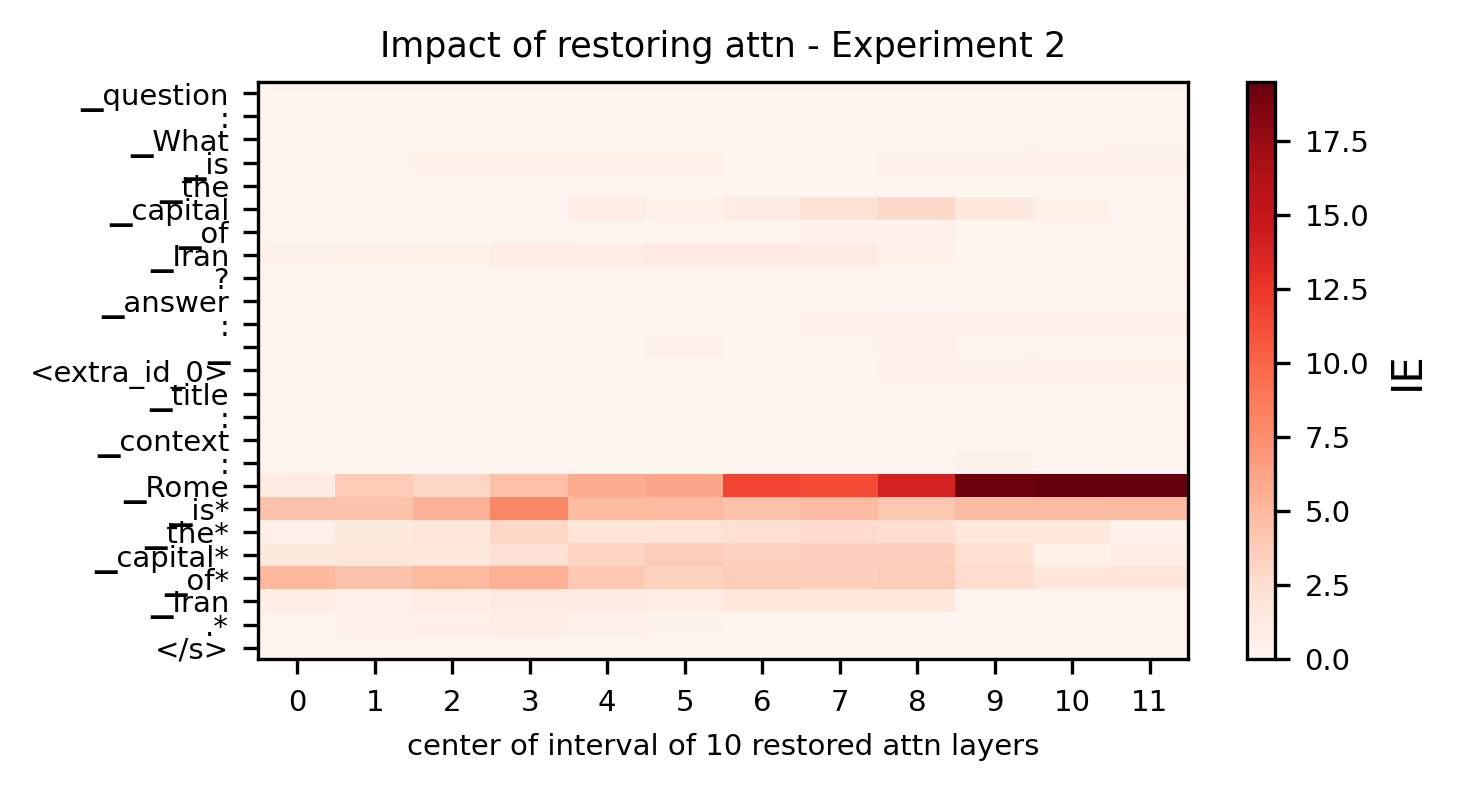

In [23]:
te_agg, ie_agg = [], []

for obj in obj_cf:
    for kind in [None, "mlp", "attn"]:
        prompt = {
            "query": f"question: What is the capital of Iran? answer: <extra_id_0>",
            "answers": ["Tehran"],
            "passages": [
                {
                    "title": " ",
                    "text": f"{obj} is the capital of Iran."
                }
            ],
            "metadata": [],
            "subj": "Iran",
            "obj": "Tehran"
        }

        experiment_args = {
            "model": model,
            "prompt": prompt,
            "samples": 6,
            "window": 6,
            "reversed_attributes": True,
            "reversed_attributes_noise": 5.1,
            "attributes": {
                obj: "context",
                prompt['subj']: "context"
            },
            "attributes_noise": {prompt['subj']: 0.0, prompt['obj']: 0.0},
            "counterfactuals": [obj],
            "num_layers": 12,
            "replace": True,
        }

        r = calculate_hidden_flow(kind=kind, **experiment_args)

        do_log = True
        te = []
        ie = []

        cr_cf_score = r.cr_cf_score
        cr_ans_score = r.cr_ans_score

        crr_score = r.crr_score
        crr_cf_score = r.crr_cf_score
        crr_ans_score = r.crr_ans_score

        crwrr_score = r.crwrr_score
        crwrr_cf_score = r.crwrr_cf_score
        crwrr_ans_score = r.crwrr_ans_score

        for i in range(experiment_args["samples"]):
            te_i = (
                safe_division(cr_cf_score[i], cr_ans_score, do_log=do_log, threshold=1e-40) 
                - 
                safe_division(crr_cf_score[i], crr_ans_score[i], do_log=do_log, threshold=1e-40)
            )
            te.append(te_i)

            ie_i = (
                safe_division(crwrr_cf_score[:, :, i], crwrr_ans_score[:, :, i], do_log=do_log, threshold=1e-40) 
                - 
                safe_division(crr_cf_score[i], crr_ans_score[i], do_log=do_log, threshold=1e-40)
            )
            ie.append(ie_i.unsqueeze(-1))

        te = torch.stack(te).mean()
        display(Latex(rf"$TE = {te}$"))

        ie = torch.cat(ie, axis=-1).mean(-1)
        ie = torch.clamp(ie, 0, None)
        display(Latex(rf"$IE = {ie.shape}$"))

        plot_trace_heatmap(
            scores=ie, 
            input_tokens=r.input_tokens, 
            answer=r.answer, 
            attributes_loc=r.attributes_loc.values(), 
            ratio=0.1,
            kindname=kind,
            title=f"Impact of restoring {kind if kind else 'state'} - Experiment 2"
        )

        # break
    break